# Kaggle Titanic Challenge

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
from sklearn import preprocessing
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV,StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from tqdm import tqdm

In [2]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

In [3]:
#seed for random values
seed =100

In [4]:
#uncomment for full dataset output
#pd.set_option('display.max_rows',None,'display.max_columns',None)
#pd.set_option('display.width', 1000)
#pd.reset_option('all')

### **Data pre-processing**

  1. Load the dataset (Source: https://www.kaggle.com/c/titanic/data)
  2. Feature engineering
  3. Filling in NA values and dropping redundant columns
  4. Scaling the data

In [5]:
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

Have a peek at what the original data looks like

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


train_data.info()

Test data won't have a survived column as that value is to be predicted

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


If you look closely, you'll see that the fare column has irregular values. The value ranges from 0 to 512 but more than 75% values are less
than 31.5 and the mean at 35.6.


Visualizing the outliers with a boxplot:

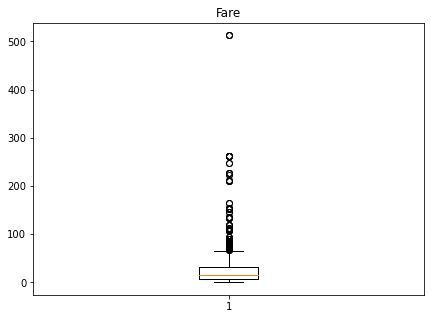

In [12]:
plt.subplots(figsize=(7,5))
plt.boxplot(train_data['Fare'])
plt.title('Fare')
plt.show()

In [13]:
train_data[train_data['Fare']>400]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


Since all these passengers have the same ticket number, we can assume that the fare was calculated for a group and not the individual. As for the rows with Fare = 0, they probably got a free pass :)

Next, analyse the null values

In [14]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Both age and cabin columns have a large number of null values, the test data has a single null fare value that we'll have to fix

Let's write some functions to fill in null values.
1. map_titles: Since there are some titles with few counts, we'll group them into categories and add a 'Title' column into the data
2. fill_null_age: I'm using 'Pclass' and 'Title' to average the age values. (Feel free to try out other columns and let me know if they work better)
3. fill_null_fare: Similar to fill_null_age, we group the data by 'Pclass' and fill in average fare values wrt to 'Pclass'

In [16]:
#extracting titles from 'Name' column and grouping titles in the same domain
def map_titles(df):
    title = df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
    df['Title'] = title 
    
    new_titles = {
        "Capt": "Officer",
        "Col": "Officer",
        "Major": "Officer",
        "Jonkheer": "Royalty",
        "Don": "Royalty",
        "Sir": "Royalty",
        "Dr": "Officer",
        "Rev": "Officer",
        "the Countess": "Royalty",
        "Dona": "Royalty",
        "Mme": "Mrs",
        "Mlle": "Miss",
        "Ms": "Mrs",
        "Mr": "Mr",
        "Mrs": "Mrs",
        "Miss": "Miss",
        "Master": "Master",
        "Lady": "Royalty"
    }
    
    df['Title'] = df['Title'].map(new_titles)


In [17]:
# function to fill in null age values by averaging ages based on Pclass and Title
def fill_null_age(df):
    temp = df.groupby(['Pclass','Title']).median()['Age']
    df.set_index(['Pclass','Title'],drop=False,inplace = True)
    df['Age'].fillna(temp,inplace=True)
    df.reset_index(drop=True,inplace=True)

# function to fill in null fare values by averaging fares based on Pclasses
def fill_null_fare(df):
    temp = df.groupby(['Pclass']).median()['Fare']
    df.set_index(['Pclass'],drop=False,inplace = True)
    df['Fare'].fillna(temp,inplace = True)
    df.reset_index(drop=True,inplace=True)

In [18]:
map_titles(train_data)
map_titles(test_data)

In [19]:
fill_null_age(train_data)
fill_null_age(test_data)

In [20]:
fill_null_fare(test_data)
fill_null_fare(train_data)

We'll now drop unnecessary rows and columns
1. Cabin: Most of the values are missing so it's better to drop the entire column
2. Name: Important features have been extracted from this column (Title) and it isn't needed anymore
3. Ticket: This column doesn't provide any useful features or information to contribute to the analysis
4. Embarked: Since there are only a few null values in this column, we can just drop the entire rows to keep it simple

In [21]:
# Drop redundant columns
train_data.drop(columns = ['Cabin','Name','Ticket'], inplace = True)
test_data.drop(columns = ['Cabin','Name','Ticket'],inplace =True)
# Drop rows will null 'Embarked columns'
train_data.dropna(subset = ['Embarked'],inplace=True)
test_data.dropna(subset = ['Embarked'], inplace= True)

Here's what the data looks like so far:

In [22]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,male,22.0,1,0,7.2500,S,Mr
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,female,26.0,0,0,7.9250,S,Miss
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,male,35.0,0,0,8.0500,S,Mr


In [23]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,male,34.5,0,0,7.8292,Q,Mr
1,893,3,female,47.0,1,0,7.0000,S,Mrs
2,894,2,male,62.0,0,0,9.6875,Q,Mr
3,895,3,male,27.0,0,0,8.6625,S,Mr
4,896,3,female,22.0,1,1,12.2875,S,Mrs


In [24]:
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64

In [25]:
test_data.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64

Finally, the data looks good enough to be used

### **Exploratory Data Analysis**
Here we use visualization methods and prebuilt pandas functions to extract new insights from the data

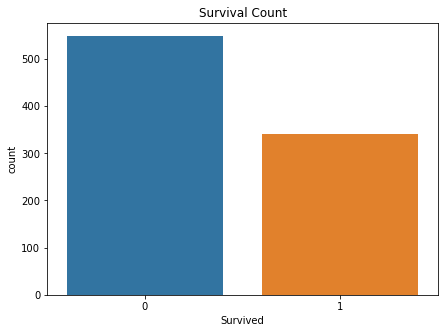

In [26]:
plt.subplots(figsize=(7,5))
sns.countplot(x='Survived', data = train_data)
plt.title('Survival Count')
plt.show()

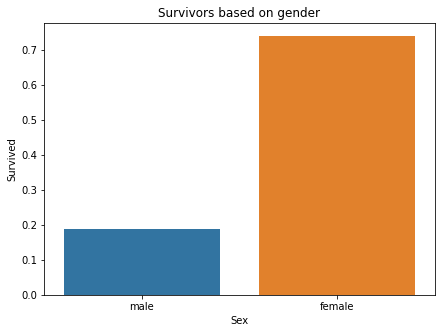

In [27]:
plt.subplots(figsize=(7,5))
sns.barplot(x='Sex',y='Survived', data = train_data, ci= None)
plt.title('Survivors based on gender')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

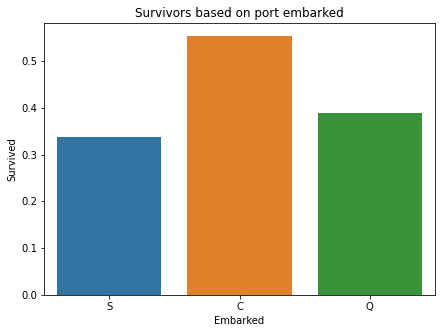

In [28]:
plt.subplots(figsize=(7,5))
sns.barplot(x='Embarked',y='Survived', data = train_data, ci = None)
plt.title('Survivors based on port embarked')
plt.show

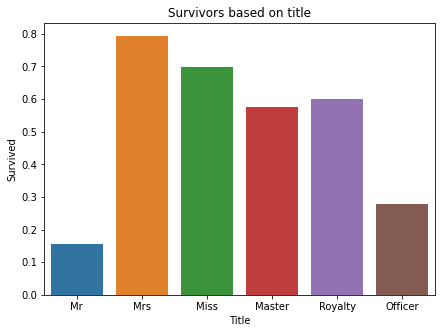

In [29]:
plt.subplots(figsize=(7,5))
sns.barplot(x='Title', y='Survived', data= train_data,ci = None)
plt.title('Survivors based on title')
plt.show()

#### Conclusions so far:
1. The count of survived are clearly imbalanced since sadly, most of the passengers did not survive. The same ratio can be expected with the test data
2. Higher survival rate for females
3. Passengers from port 'C' have a greated number of survivors compared to the others
4. Based on titles, 'Mrs' and 'Ms' survived the most (evident from 2.) along with 'royalty' 

Converting categorical variables to integers and scaling data before calculating correlation

In [30]:
le = preprocessing.LabelEncoder()
# convert Male/Female to 0/1
train_data['Sex'] = le.fit_transform(train_data['Sex'])
test_data['Sex'] = le.transform(test_data['Sex'])
# create dummy variables for 'Title' and 'Embarked' columns
train_data = pd.get_dummies(train_data, columns = ['Title','Embarked'])
test_data = pd.get_dummies(test_data, columns = ['Title','Embarked'])

In [31]:
scaler = MinMaxScaler()
# scale data between the range of [0,1]
train_data.iloc[:,2:] = scaler.fit_transform(train_data.iloc[:,2:])
test_data.iloc[:,1:] = scaler.transform(test_data.iloc[:,1:])

This is what the dataset looks like now

In [32]:
train_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,1,0,1.0,1.0,0.271174,0.125,0.000000,0.014151,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1,0.0,0.0,0.472229,0.125,0.000000,0.139136,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,1,1.0,0.0,0.321438,0.000,0.000000,0.015469,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1,0.0,0.0,0.434531,0.125,0.000000,0.103644,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5,0,1.0,1.0,0.434531,0.000,0.000000,0.015713,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,0.5,1.0,0.334004,0.000,0.000000,0.025374,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
887,888,1,0.0,0.0,0.233476,0.000,0.000000,0.058556,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
888,889,0,1.0,0.0,0.220910,0.125,0.333333,0.045771,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
889,890,1,0.0,1.0,0.321438,0.000,0.000000,0.058556,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
test_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,892,1.0,1.0,0.428248,0.000,0.000000,0.015282,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,893,1.0,0.0,0.585323,0.125,0.000000,0.013663,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,894,0.5,1.0,0.773813,0.000,0.000000,0.018909,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,895,1.0,1.0,0.334004,0.000,0.000000,0.016908,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,896,1.0,0.0,0.271174,0.125,0.166667,0.023984,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,1.0,1.0,0.308872,0.000,0.000000,0.015713,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
414,1306,0.0,0.0,0.484795,0.000,0.000000,0.212559,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
415,1307,1.0,1.0,0.478512,0.000,0.000000,0.014151,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
416,1308,1.0,1.0,0.308872,0.000,0.000000,0.015713,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
corr = train_data.corr()
corr

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005028,-0.035330,0.043136,0.040160,-0.057686,-0.001657,0.012703,-0.026218,-0.064014,0.039008,0.005437,0.055440,0.031681,-0.001208,-0.033694,0.022269
Survived,-0.005028,1.000000,-0.335549,-0.541585,-0.067616,-0.034040,0.083151,0.255290,0.085998,0.332094,-0.547689,0.343836,-0.030963,0.033666,0.169966,0.004536,-0.151777
Pclass,-0.035330,-0.335549,1.000000,0.127741,-0.412504,0.081656,0.016824,-0.548193,0.081547,-0.006737,0.139156,-0.151780,-0.149428,-0.118241,-0.245733,0.220558,0.076466
Sex,0.043136,-0.541585,0.127741,1.000000,0.108472,-0.116348,-0.247508,-0.179958,0.159612,-0.692363,0.866888,-0.552629,0.088976,-0.007728,-0.084520,-0.075217,0.121405
Age,0.040160,-0.067616,-0.412504,0.108472,1.000000,-0.270207,-0.183632,0.118389,-0.396495,-0.302457,0.213892,0.191948,0.190200,0.069937,0.050357,-0.104776,0.021835
SibSp,-0.057686,-0.034040,0.081656,-0.116348,-0.270207,1.000000,0.414542,0.160887,0.349434,0.085939,-0.252201,0.061261,-0.024872,-0.008467,-0.060074,-0.026692,0.069438
Parch,-0.001657,0.083151,0.016824,-0.247508,-0.183632,0.414542,1.000000,0.217532,0.267194,0.103551,-0.335765,0.223240,-0.048377,-0.035673,-0.011588,-0.081585,0.061512
Fare,0.012703,0.255290,-0.548193,-0.179958,0.118389,0.160887,0.217532,1.000000,0.011390,0.119660,-0.181692,0.103920,0.010679,0.015222,0.270731,-0.116684,-0.163758
Title_Master,-0.026218,0.085998,0.081547,0.159612,-0.396495,0.349434,0.267194,0.011390,1.000000,-0.110509,-0.255888,-0.088206,-0.031204,-0.016324,-0.035471,0.010330,0.024577
Title_Miss,-0.064014,0.332094,-0.006737,-0.692363,-0.302457,0.085939,0.103551,0.119660,-0.110509,1.000000,-0.600201,-0.206893,-0.073190,-0.038290,0.038498,0.169631,-0.140514


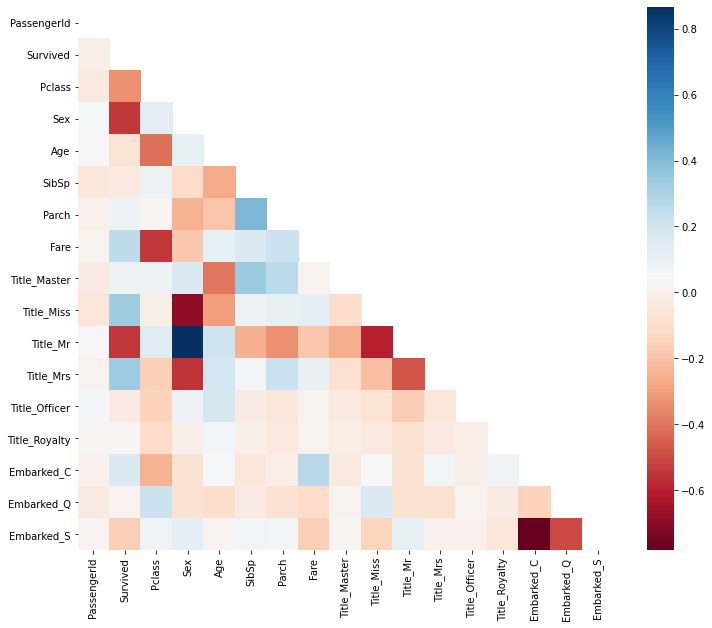

In [35]:
# mask to hide the upper triangle in the heatmap (this is done as correlation values are symmetrical on either sides of the diagonal)
mask = np.triu(np.ones_like(corr,dtype=bool))

# set up the plot
f,ax = plt.subplots(figsize = (12,10))

# plot heatmap
sns.heatmap(corr,mask=mask,cmap = 'RdBu')
plt.show()

From the above correlation heatmap, we see that:
1. 'Survival' has a relatively weak positive correlation with 'Pclass', 'Sex', and 'Title_Mr'
2. 'Survival' has a relatively strong positive correlation with 'Fare', 'Title_Miss', 'Title_Mrs'. 'Embarked_C' (This is evident from the bar plots above)

In [36]:
# divide data into respective subsets
X_train, X_test, y_train = train_data.iloc[:, 2:], test_data.iloc[:, 1:], train_data['Survived']

### **Model Training**

In [37]:
#empty list to store best train and test scores
scores = []

In [38]:
# function to run model on test data and generate a csv file for submission
def generate_predict_file(preds,clf_name):
    test_data['Survived'] = preds
    predictions = test_data[['PassengerId','Survived']]
    predictions.to_csv(f"submission_{clf_name}", index = False)

## Logistic Regression

In [39]:
logreg = LogisticRegression()

# parameters to test
params = [{'penalty' : ['l1','l2','elasticnet','none'],
          'C' : [0.001,0.01,0.1,1,10,100,1000]}]

# cross validation
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats = 10,random_state = seed)

#gridsearch
lr_gs = GridSearchCV(logreg, params, cv=cv, n_jobs = -1)
lr_gs.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=100),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none']}])

In [40]:
# best parameters from gridsearch
lr_gs.best_params_

{'C': 10, 'penalty': 'l2'}

In [41]:
# best score from best gridsearch parameters
lr_gs.best_score_

0.8304697517933093

In [42]:
# prediction on test data
y_preds = lr_gs.predict(X_test)
generate_predict_file(y_preds,"LogReg")
# after submitting, test score = 0.76555
test_score = 0.76555

In [43]:
# append train and test scores to list
scores.append(['Logistic Regression', lr_gs.best_score_, test_score])

## Support Vector Classifier

In [ ]:
svm = SVC(max_iter=10000)

#parameters to tune
params = [{'C' : [0.001,0.01,0.1,1,10,100,1000],
           'kernel' : ['linear','poly','rbf','sigmoid']}]
#gridsearch
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=10, random_state=seed)
svm_gs = GridSearchCV(svm,params,cv=cv,n_jobs=-1)
svm_gs.fit(X_train, y_train)

In [ ]:
#best parameters
svm_gs.best_params_

In [ ]:
#best score
svm_gs.best_score_

In [ ]:
# prediction and file generation
y_preds = svm_gs.predict(X_test)
generate_predict_file(y_preds,"svc")

In [ ]:
# after submitting, test score = 0.77751
test_score = 0.77751
# add scores to list
scores.append(['SVC',svm_gs.best_score_,test_score])

## K - Nearest Neighbours

In [ ]:
knn = KNeighborsClassifier()

# Parameters to test. p=1 : Manhattan distance, p=2 : Euclidian distance
params = [{'n_neighbors': range(1,21),
          'p' : [1,2]}]

# grid search
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10,random_state=seed)
gs_knn = GridSearchCV(knn, params, cv=cv, n_jobs=-1)
gs_knn.fit(X_train, y_train)

In [ ]:
# best parameters
gs_knn.best_params_

In [ ]:
# best score
gs_knn.best_score_

In [ ]:
# prediction and file gen
y_preds = gs_knn.predict(X_test)
generate_predict_file(y_preds,"KNN")

In [ ]:
#after submitting, test score = 0.78229
test_score = 0.78229

# add scores to list
scores.append(['KNN',gs_knn.best_score_,test_score])

## Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier(random_state=seed)

#params to tune
params = [{'criterion' : ['gini','entropy'],
           'max_depth': [5, 7, 10, None],
           'min_samples_split': [2, 5, 10],
           'max_features': ['sqrt', 5, 7, 10]}]
#grid search
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed)
gs_dt = GridSearchCV(dt,params,cv=cv,n_jobs=-1)
gs_dt.fit(X_train,y_train)

In [ ]:
# best parameters
gs_dt.best_params_

In [ ]:
# best score
gs_dt.best_score_

In [ ]:
# predictions and file gen
y_preds = gs_dt.predict(X_test)
generate_predict_file(y_preds,"DecisionTree")

In [ ]:
#after submitting, test score = 0.77511
test_score = 0.77511
# add scores to list
scores.append(['Decision Tree',gs_dt.best_score_,test_score])

## Gaussian Naive Bayes

In [ ]:
# model using default params
gb = GaussianNB()
gb.fit(X_train,y_train)

In [ ]:
# prediction and file gen
y_preds = gb.predict(X_test)
generate_predict_file(y_preds,"GaussianNB")

In [ ]:
#after submitting, test score = 0.7511
test_score = 0.7511

# add scores to list
scores.append(['GaussianNB',None,test_score])

## Random Forest Classifier

In [ ]:
#Performing grid search on a random forest is computationally expensive
rfc = RandomForestClassifier(random_state=seed,verbose=1)
rfc.fit(X_train,y_train)

In [ ]:
# prediction and file gen
y_preds = rfc.predict(X_test)
generate_predict_file(y_preds,"RFC")

In [ ]:
#after submitting, test score = 0.74880
test_score = 0.74880

# add scores to list
scores.append(['Random Forrest Classifier', None, test_score])

## **Comparing Models**

In [ ]:
#creating a new dataframe to compare train and test scores for different models
score_df = pd.DataFrame(scores, columns = ['Classifier','Train Score', 'Test Score'])
score_df

In [ ]:
plt.subplots(figsize=(20,10))
sns.barplot(x='Classifier',y='Train Score', data = score_df)
plt.title('Train Score')
plt.show()

In [ ]:
plt.subplots(figsize=(20,10))
sns.barplot(x='Classifier',y='Test Score', data = score_df)
plt.title('Test Score')
plt.show()

# **Conclusion**